# Exercise 06: PCA & Latent Semantic Analysis

In this exercise we will implement
- PCA using eigendecompositions and using SVD on the appropriate matrices and
- Latent Semantic Analysis

You must implement all required functionality using standard numpy functions for linear algebra operations (do not use the statistical functions like cov and mean etc. for example).
For LSA we will make an exception and use some ready-made functions from scikit-learn.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## PCA

In [3]:
# Load MNIST dataset containing
# - 70,000 samples of hand-written digits (28x28 pixel values)

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target
X = X.astype(np.float64)
print(X.shape)

(70000, 784)


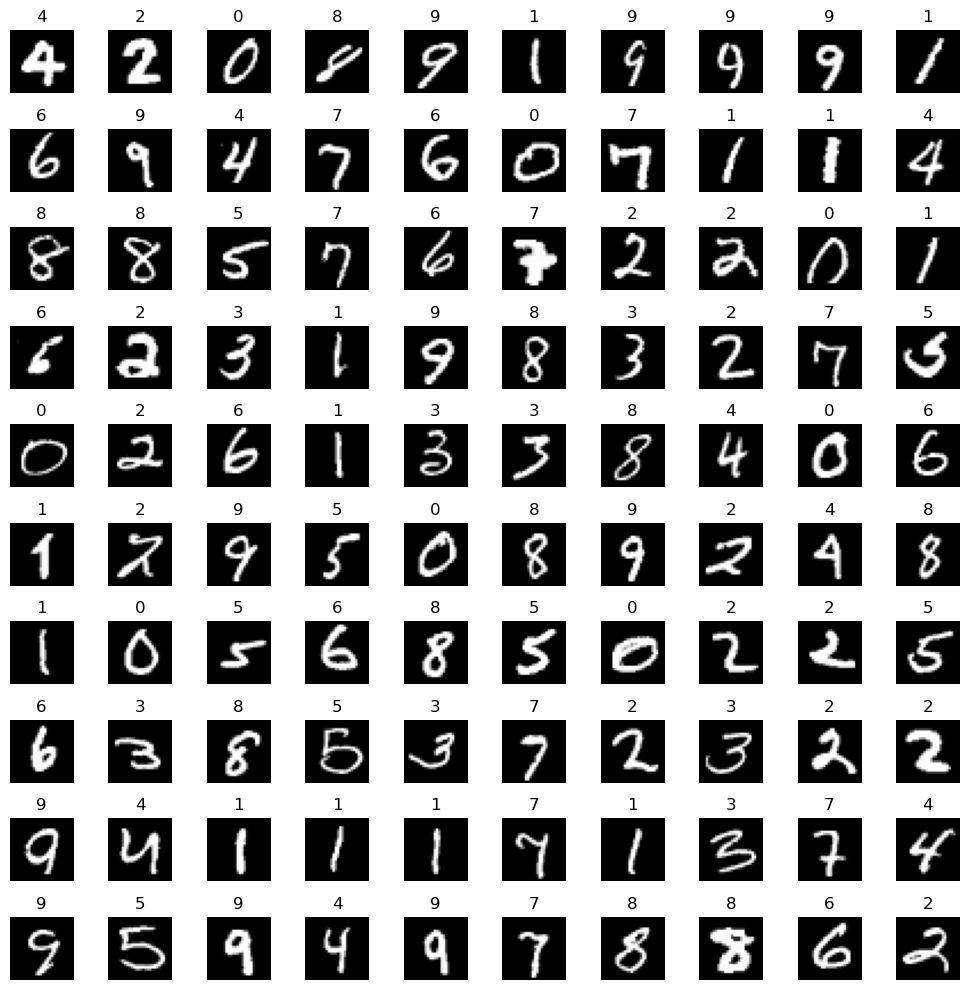

In [4]:
# Visualize random 100 samples
random_indices = np.random.choice(X.shape[0], 100, replace=False)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[random_indices[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"{y[random_indices[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# center data of n x m matrix X, where n is number of samples and m number of features
def center_data(X):
    N = X.shape[0]
    means =  np.sum(X, axis=0) / N
    return X - means

In [6]:
# check shapes of centered data
X_centered = center_data(X)
X_centered.shape

(70000, 784)

In [7]:
from mlxtend.preprocessing import MeanCenterer

X_train = np.copy(X)
mc = MeanCenterer().fit(X_train)
mc.transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
# check implementation of data centering
np.array_equal(X, X_train, equal_nan=False)

True

In [ ]:
# compute covariance matrix of n x m matrix X
# X must be centered first!
def covariance_matrix(X):
    N = X.shape[0]
    Cov = (X.T @ X) / (N - 1)
    return Cov 

In [9]:
# given n x m matrix X, where n is number of samples and m number of features, compute PCA
def PCA(X, n_components):
    # center the data
    X_c = center_data(X)
    Cov = covariance_matrix(X_c)
    eigenvalues, eigenvectors = np.linalg.eigh(Cov)

    sorted_indices = np.argsort(eigenvalues)[::-1]  # indices for sorting in descending order
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    PCA_matrix = eigenvectors[:, :n_components] # Shape: (784, n_components)

    # project centered data on PC
    X_pca = X_c @ PCA_matrix    # Shape (70000, 2)

    return X_pca

In [ ]:
def PCA_via_SVD(X, n_components):
    X_c = center_data(X)
    U, Sigma, V_T = np.linalg.svd(X_c, full_matrices=False)
    PCA_matrix = V_T.T[:, :n_components] # Shape: (784, 2)

    # project centered data on PC
    X_pca_svd = X_c @ PCA_matrix
    
    return X_pca_svd

In [11]:
X_pca = PCA(X, 2)
X_pca.shape

(70000, 2)

In [12]:
X_pca_svd = PCA_via_SVD(X, 2)
X_pca_svd.shape

(70000, 2)

In [13]:
# Visualize the first two principal components
def visualize_2d(X, y):
    y = y.astype(int)

    # Plot the first two principal components
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter, ticks=range(10), label='Digit Label')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of MNIST Dataset')
    plt.show()

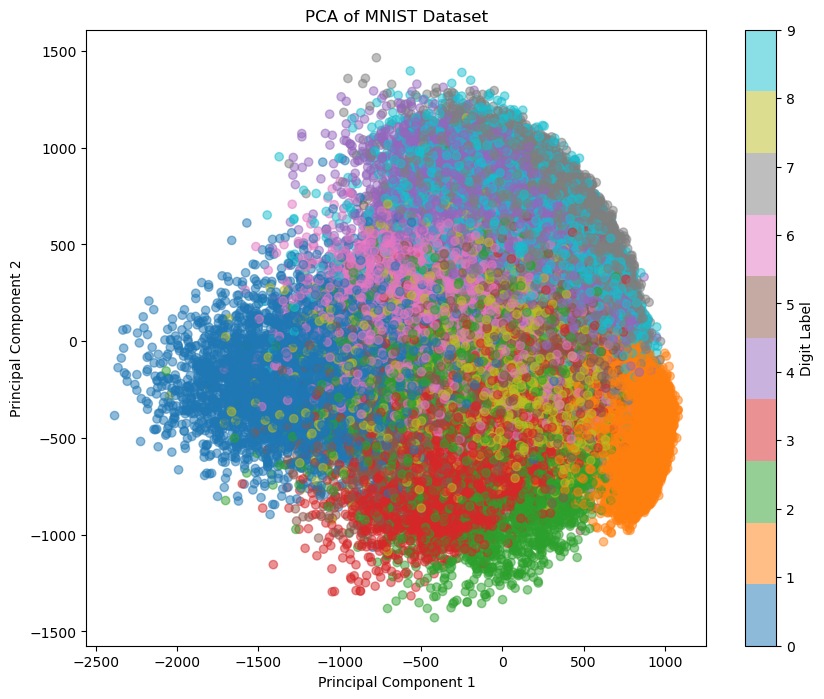

In [14]:
visualize_2d(X_pca, y)

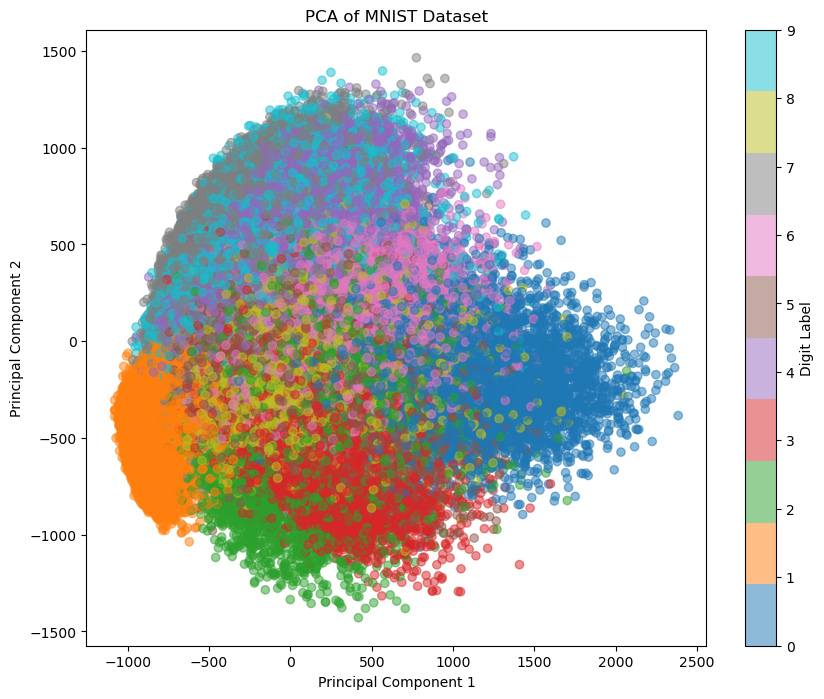

In [15]:
visualize_2d(X_pca_svd, y)

## Latent Semantic Analysis

In [16]:
from sklearn.datasets import fetch_20newsgroups
import re
from collections import defaultdict
from typing import List
from math import log

categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))

In [17]:
# We will use pre-made tokenizer and word count functionality from sklearn
# TF = term frequency
# IDF = inverse document frequency
# TFIDF = TF * IDF <- normalized term frequency
# We use sklearn to this end.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
TFIDF = vectorizer.fit_transform(newsgroups.data)
vectorizer_tf = TfidfVectorizer(use_idf=False)
TF = vectorizer_tf.fit_transform(newsgroups.data)
print(TFIDF.shape) # 2034 documents, 26879 words in total

(2034, 26879)


In [18]:
from sklearn.decomposition import TruncatedSVD
n_components = 16  # Number of components to keep
svd = TruncatedSVD(n_components=n_components)
# Perform SVD on the TFIDF matrix
TFIDF_transformed = np.array(svd.fit_transform(TFIDF))
V = svd.components_
print(TFIDF_transformed.shape)
print(V.shape)

(2034, 16)
(16, 26879)


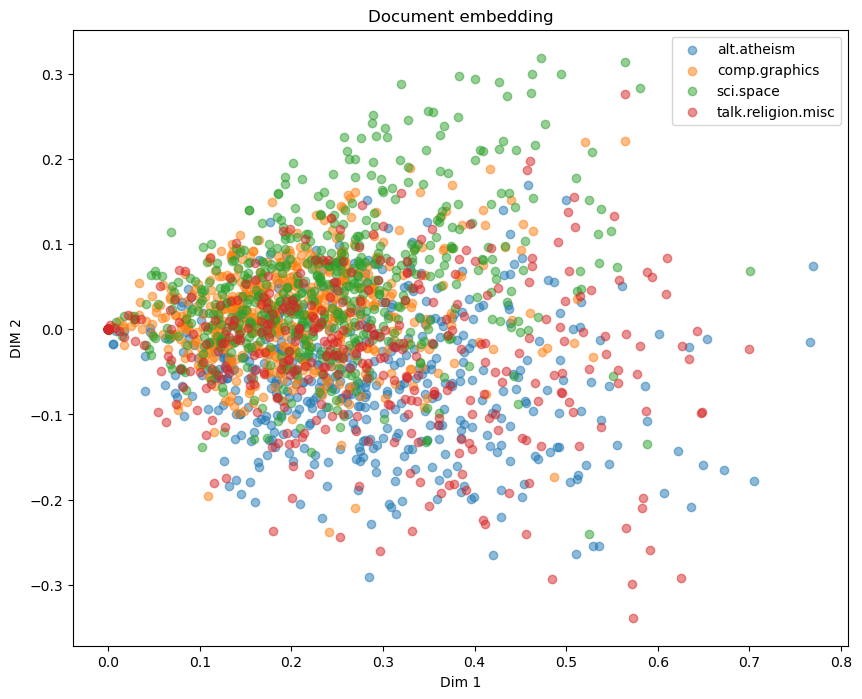

In [19]:
# Evaluate document similarity in the reduced space
def visualize_docs(docs_rep, docs_categories, categories):
    docs_categories = docs_categories.astype(int)

    # Plot the first two principal components
    plt.figure(figsize=(10, 8))
    for i in range(len(categories)):
        mask = docs_categories == i
        plt.scatter(docs_rep[mask, 0], docs_rep[mask, 1], label=categories[i], alpha=0.5)
    plt.legend()
    plt.xlabel('Dim 1')
    plt.ylabel('DIM 2')
    plt.title('Document embedding')
    plt.show()

visualize_docs(TFIDF_transformed, newsgroups.target, categories)

In [37]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

# Print the most important words for each topic
# For each of the 16 topics that we have, search for the 10 words such that their values in V are the largest
# print out the words
def print_topics(V, vocab):
    top_n = 10
    for topic_id, topic in enumerate(V):
        top_indices = topic.argsort()[::-1][:top_n]
        top_words = [vocab[i] for i in top_indices]
        print(f"Topic {topic_id + 1}: {', '.join(top_words)}")

In [42]:
print_topics(V, vocab)

Topic 1: the, to, of, and, is, that, it, in, you, for
Topic 2: the, space, of, and, on, in, nasa, for, data, was
Topic 3: the, of, that, god, he, was, they, jesus, not, his
Topic 4: is, objective, of, does, there, an, morality, that, god, not
Topic 5: you, space, your, of, are, nasa, is, the, system, morality
Topic 6: it, space, be, that, would, to, was, we, nasa, think
Topic 7: he, was, his, to, jesus, you, him, me, koresh, who
Topic 8: the, it, you, was, file, files, cview, bit, screen, don
Topic 9: of, this, graphics, was, in, about, just, an, group, one
Topic 10: he, it, is, space, god, nasa, and, for, your, cview
Topic 11: that, would, be, any, for, thanks, objective, looking, or, the
Topic 12: and, he, graphics, objective, be, image, system, morality, you, are
Topic 13: he, is, to, so, what, an, his, if, the, islam
Topic 14: objective, was, that, morality, they, and, what, are, we, space
Topic 15: that, to, file, files, atheism, this, nasa, tiff, format, cview
Topic 16: do, graph

In [60]:
# Do document retrievel
# Given a list of query words, look up their representation via their entries in matrix V and sum up all representations into a query vector
# normalize the query vector to have unit length
# multiply with TFIDF_transformed and sort the results in descending order
# print out the top 5 documents

def retrieve(terms, vocab, V, TFIDF_transformed, docs):
    top_n = 5
    query_vector = np.zeros(V.shape[0])
    for word in terms:
        if word in vocab:
            word_index = np.where(vocab == word)[0][0]
            query_vector += V[:, word_index]

    norm_vector = query_vector / np.linalg.norm(query_vector)
    query = TFIDF_transformed @ norm_vector

    top_indices = np.argsort(query)[::-1][:top_n]

    top_documents = [docs[i] for i in top_indices]

    [print(f"Doc: {i + 1}, text: {top_documents[i]}") for i in range(5)]

In [61]:
retrieve(['jesus'], vocab, V, TFIDF_transformed, newsgroups.data)

Doc: 1, text: 

	Agreed.

--


       "Satan and the Angels do not have freewill.  
        They do what god tells them to do. "
Doc: 2, text: 

	I agree, we spend too much energy on the nonexistance of God.

--


       "Satan and the Angels do not have freewill.  
        They do what god tells them to do. "
Doc: 3, text: : I will clarify my earlier quote.  God's laws were originally written for 
: the Israelites.  Jesus changed that fact by now making the Law applicable to
: all people, not just the Jews.  Gentiles could be part of the kingdom of
: Heaven through the saving grace of God.  I never said that the Law was made
: obsolete by Jesus.

Just for reference, here's the earlier quote:
Malcolm Lee (mlee@post.RoyalRoads.ca) wrote in reference to Leviticus 21:9
and Deuteronomy 22:20-25:
: These laws written for the Israelites, God's chosen people whom God had
: expressly set apart from the rest of the world.  The Israelites were a
: direct witness to God's existence.  To disobey G

In [62]:
retrieve(['war'], vocab, V, TFIDF_transformed, newsgroups.data)

Doc: 1, text: I told some friends of mine two weeks ago that Koresh was dead.  The FBI and
the BATF could not let a man like that live.  He was a testimonial to their
stupidity and lies.    

Now before everyone gets crazy with me, let me say that Koresh was crazy as 
a bed bug, but out government was crazier...and they lied to us.

They told us compound had been under survaillance for quite some time.  Yet, 
whoever was watching the place failed to see that Koresh went jogging and into
town on a regular basis.  Everyone in the area claimed to have seen him and 
wondered why they didn't pick him up then.  There are two possible answers.
First, they didn't see him.  What kind of survaillance is that?  Second, they
didn't care.  They wanted a confrontation.  They wanted publicity and they got
it.

After the first battle, they told us that they did not know he knew they were
coming.  They also said it would have been foolish to go in knowing that.
Well, we know now that they intercepted t

In [63]:
retrieve(['crazy'], vocab, V, TFIDF_transformed, newsgroups.data)

Doc: 1, text: : 
:   Nut or not, he was clearly a liar.  He said he would surrender after
:   local radio stations broadcast his message, but he didn't.  Then he
:   said he would surrender after Passover, but he didn't.
: 
Doc: 2, text: 

I _know_ I shouldn't get involved, but...   :-)

[bit deleted]


Righto, DAN, try this one with your Cornflakes...

The book says that Muhammad was either a liar, or he was crazy ( a 
modern day Mad Mahdi) or he was actually who he said he was.
Some reasons why he wouldn't be a liar are as follows.  Who would 
die for a lie?  Wouldn't people be able to tell if he was a liar?  People 
gathered around him and kept doing it, many gathered from hearing or seeing 
how his son-in-law made the sun stand still.  Call me a fool, but I believe 
he did make the sun stand still.  
Niether was he a lunatic.  Would more than an entire nation be drawn 
to someone who was crazy.  Very doubtful, in fact rediculous.  For example 
anyone who is drawn to the Mad Mahdi i

In [65]:
retrieve(['terrorist'], vocab, V, TFIDF_transformed, newsgroups.data)

Doc: 1, text: : Concerning the proposed newsgroup split, I personally am not in favor of
: doing this.  I learn an awful lot about all aspects of graphics by reading
: this group, from code to hardware to algorithms.  I just think making 5
: different groups out of this is a wate, and will only result in a few posts
: a week per group.  I kind of like the convenience of having one big forum
: for discussing all aspects of graphics.  Anyone else feel this way?
: Just curious.


: Daemon

What he said...

-- 
Doc: 2, text: Concerning the proposed newsgroup split, I personally am not in favor of
doing this.  I learn an awful lot about all aspects of graphics by reading
this group, from code to hardware to algorithms.  I just think making 5
different groups out of this is a wate, and will only result in a few posts
a week per group.  I kind of like the convenience of having one big forum
for discussing all aspects of graphics.  Anyone else feel this way?
Just curious.

Doc: 3, text: : Conc